## Use CNN + template matching to estimate coordinates - Final inference notebook

In [2]:
# # Only to run when using COLAB
# !mkdir data
# !mkdir data/test

# # test data for the challenge 
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CV1__7oQQl14tWzUXkr-_BJwop6Gnhbs' -O test.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tG-uDCYyjwcCZyCYR7typ4lyj5x_GEIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tG-uDCYyjwcCZyCYR7typ4lyj5x_GEIP" -O testImages.zip && rm -rf /tmp/cookies.txt
# !ls -ltr .

# # unzip test images into its folders
# !unzip -o testImages.zip -d ./data/test/ 
# !ls  ./test/*.png | wc -l
# !ls -ltr . 

# # Download train files
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fuaPrB210tMS3bYhAr9I2JIsXyjcuYgC' -O data/train.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oIXTEvLlr7WSe28c9E_HWuowZE5bnq7q' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1oIXTEvLlr7WSe28c9E_HWuowZE5bnq7q" -O trainImages.zip && rm -rf /tmp/cookies.txt

# # Leaked test files, that I decided to use for training the model
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1skDLd9kLGz0LX4gOSSusaTj3pdYx-Ja2' -O data/trainNew.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15MDsiiuMOy8i6dbGbQJ0cCWr5SG9LFQR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15MDsiiuMOy8i6dbGbQJ0cCWr5SG9LFQR" -O trainImagesNew.zip && rm -rf /tmp/cookies.txt
# !ls -ltr .

# # unzip train images into its folders
# !unzip -o trainImages.zip -d ./data/train/
# !unzip -o trainImagesNew.zip -d ./data/train/
# !ls  ./data/train/*.png | wc -l
# !ls -ltr .

In [27]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import numpy as np
import pandas as pd
import math
import random
from datetime import datetime
import json
from tqdm import tqdm
from multiprocessing import Pool
import math
import pickle
from multiprocessing import Pool, cpu_count

from sklearn.cluster import KMeans

# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

# -------------
# own modules
# -------------
from util import *
from map_image import MapImage
from data_generator import DataGenerator
from model_factory import create_vgg_based_model

# custom object that acts as a wrapper. It essentially contains
# a dictionary that maps each cluster to a list of representative maps
# from the train set
from cluster_representative_maps import ClusterRepresentativeMaps

2.1.0


In [32]:
N_CLASSES = N_MAP_CLUSTERS = 150

# Create train/test split or load it from csv file
TRAIN_IMAGES_DIR = 'data/train/'
TEST_IMAGES_DIR = 'data/piom_new_test_10k/'

# Part 1: CNN training
# ------------------------
IMAGE_WIDTH = IMAGE_HEIGHT = 128
BACKBONE_NN = 'VGG16'
LOAD_CNN_PREDICTIONS_FROM_DISK = False
MODEL_WEIGHTS = './saved_weights/150clusters_VGG16_90epochs_final/'
#CNN_PREDICTIONS_FILE = './saved_model_predictions/test_non_leaked.npy'

# Part 2: Template matching for coordinates calculation
# ------------------------
N_CLUSTER_CANDIDATES = 10
N_MAPS_PER_CLUSTER = 16
N_CROPS = 3
RESIZE_FACTOR_TEMPLATE_MATCHING = 0.25
THRESHOLD_PROB_FIRST_CLUSTER = 0.70

In [7]:
# For inference I need:

# - CNN model to get cluster candidates and probs. - done
# - Mapping cluster --> {representative maps} - ...
# - Infer final coordinates.



### Load coordinates file train and test

In [8]:
# train
train = pd.read_csv('data/train.csv', index_col=0)
trainNew = pd.read_csv('data/trainNew.csv', index_col=0)
train = pd.concat([train, trainNew], axis=0)
print(train.head(10))
train_ids = train['id'].tolist()
print('Train images: ', len(train_ids))

# test
test = pd.read_csv('data/piom_new_test_10k.csv', index_col=0)
print(test.head(10))
test_ids = test['id'].tolist()
print('Test images: ', len(test_ids))

ids = train_ids + test_ids
print('Total images: ', len(ids))

           id   llcrnrlon  llcrnrlat   urcrnrlon  urcrnrlat
0  aa5b6e01eb   52.635221  21.939847   60.276093  28.262239
1  e5a3b9d07d  123.974550  -6.746330  129.139013  -0.813028
2  3d7cedf92f  106.033993  10.328013  112.494841  18.005732
3  6f2fdf0368   54.051684  22.264178   59.123211  26.997385
4  5addc798b4  -40.403236  62.752617  -26.507330  70.153543
5  ddb27f85c0  -78.989740 -54.391308  -67.924797 -47.881368
6  d7e09a4a31  -52.643921  58.749963  -42.687544  62.697276
7  5bd2f2d225   77.343019   8.265528   82.347628  14.510404
8  89a14f09d8  -62.540592  44.760961  -55.601705  50.819461
9  980fc0a257  154.860601  67.369130  170.047838  71.235238
Train images:  40000
            id  llcrnrlon  llcrnrlat  urcrnrlon  urcrnrlat
0   00086b9060        NaN        NaN        NaN        NaN
1   001b71f4dd        NaN        NaN        NaN        NaN
2   002001fdfb        NaN        NaN        NaN        NaN
3   0020667201        NaN        NaN        NaN        NaN
4   0023c139f2        Na

### Check common ids between train and test sets... THERE ARE!

In [9]:
common_ids = list(set(train_ids) & set(test_ids))
print(len(common_ids))
print('Common ids: ', common_ids)
# print('Check: ', len(list(set(ids))) == len(ids))

7881
Common ids:  ['c19465cdb7', '5753fc171d', '61b590a30a', '193de08fad', '6dbbb70276', '17f3e91091', '94427c401b', '8b0a33c7f9', 'f3adab8c65', '247d81550c', 'c4629df64c', '31a77f81e2', '1c5ea71b8d', 'a390de1840', '079014a3df', 'a080666abe', 'eb31318a43', 'ea4d569396', 'ac3e4ec9f2', 'd73cc0dcba', '798e47b6fa', 'baa3ad75a8', '01321ddcdb', 'acecb5bf26', '15800f6bff', '8d00025b0f', '08db04785d', '45fffaa26e', '94e7753561', 'c1ba251e1b', '9208b20fee', 'be2b24e17d', '4be464a960', '6ff9dc1aee', 'dbff7242ee', '92f84ee9e5', '9fc61aa3a8', '635f3c36ac', '23aeefeac0', '767b351d5d', '6cd6c23f83', 'e037f3d9c7', 'efd2ebd854', 'f769d33669', 'aff92abde6', '72af7b3c06', 'a5b51026f0', 'a280c348d3', 'c30b3eca7b', '902f4ee6f2', '7447b08a14', '9491b92b18', 'caf1e6b863', '42746c39ee', '51a571fb35', '091928c077', '6d1a4a583e', 'c73f9774c6', 'cb6e697879', '479fca7322', '5c76dc41f3', 'c9d9684def', '589abc96da', '2dbb22b250', '5d65035a60', '5035634eb1', '1e45f29bf7', '1604f594ef', 'da533e0e87', '591dec4edf', '

### Confirm that same image_id means same image

image_id:  c19465cdb7
data/train/c19465cdb7.png


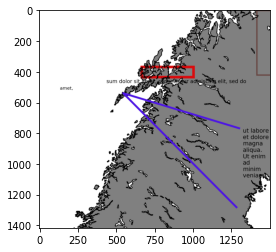

data/piom_new_test_10k/c19465cdb7.png


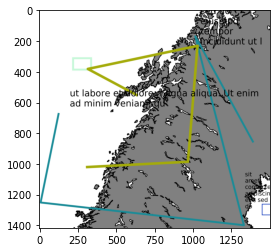

image_id:  5753fc171d
data/train/5753fc171d.png


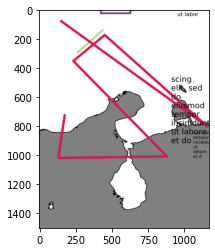

data/piom_new_test_10k/5753fc171d.png


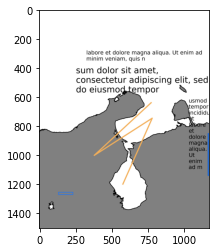

image_id:  61b590a30a
data/train/61b590a30a.png


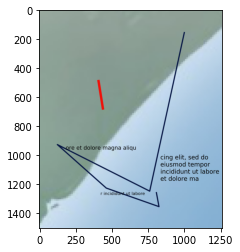

data/piom_new_test_10k/61b590a30a.png


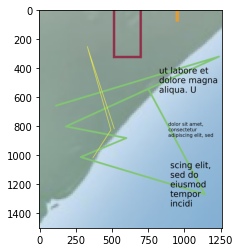

image_id:  193de08fad
data/train/193de08fad.png


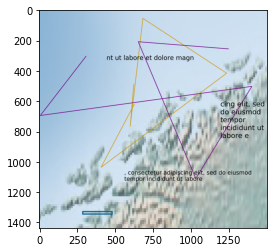

data/piom_new_test_10k/193de08fad.png


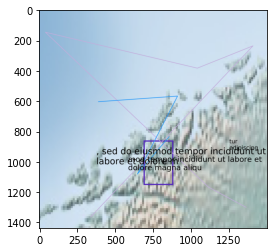

image_id:  6dbbb70276
data/train/6dbbb70276.png


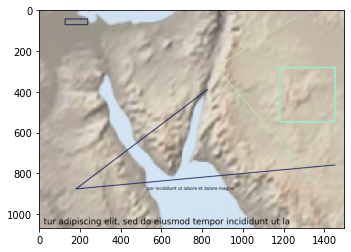

data/piom_new_test_10k/6dbbb70276.png


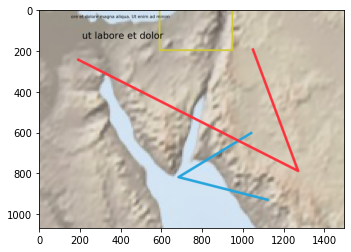

image_id:  17f3e91091
data/train/17f3e91091.png


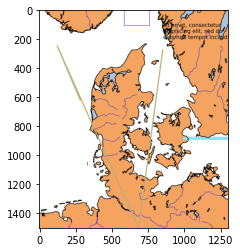

data/piom_new_test_10k/17f3e91091.png


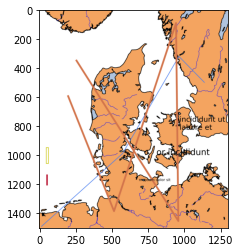

image_id:  94427c401b
data/train/94427c401b.png


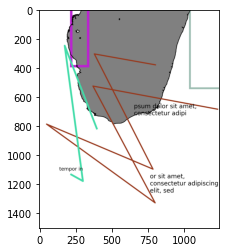

data/piom_new_test_10k/94427c401b.png


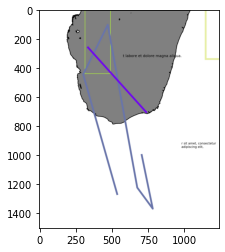

image_id:  8b0a33c7f9
data/train/8b0a33c7f9.png


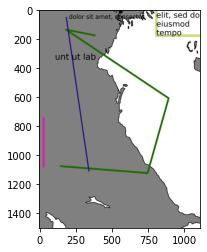

data/piom_new_test_10k/8b0a33c7f9.png


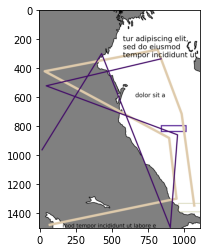

image_id:  f3adab8c65
data/train/f3adab8c65.png


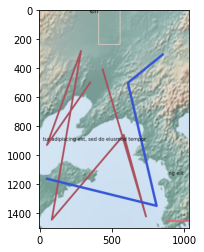

data/piom_new_test_10k/f3adab8c65.png


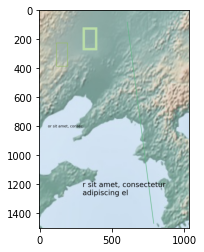

image_id:  247d81550c
data/train/247d81550c.png


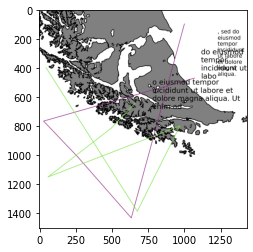

data/piom_new_test_10k/247d81550c.png


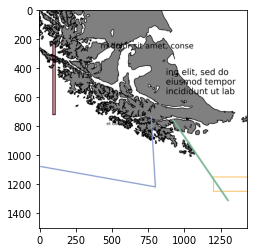

In [10]:
for image_id in common_ids[:10]:
    
    print('image_id: ', image_id)
    
    # train image
    train_image_path = id2path(TRAIN_IMAGES_DIR, image_id)
    print(train_image_path)
    train_image = MapImage(image_id=image_id,
                           image_path=train_image_path)
    train_image.plot()
    
    # test image
    test_image_path = id2path(TEST_IMAGES_DIR, image_id)
    print(test_image_path)
    test_image = MapImage(image_id=image_id,
                          image_path=test_image_path)
    
    test_image.plot()

### Auxiliary mapping

In [22]:
# image_id --> image_path
map_id_to_train_path = dict()
for image_id in train['id']:
    map_id_to_train_path[image_id] = id2path(TRAIN_IMAGES_DIR, image_id)

map_id_to_path = dict()
for image_id in test_ids:
    map_id_to_path[image_id] = id2path(TEST_IMAGES_DIR, image_id)

## 1. Pick up coordinates for the leaked ids from the train set

In [14]:
# For common_ids use known coordinates from train set
map_id_to_predicted_coordinates = dict()
common = pd.merge(train, test['id'], on='id')
for _, row in common.iterrows():
    map_id_to_predicted_coordinates[row['id']] = [
        row['llcrnrlon'],
        row['llcrnrlat'],
        row['urcrnrlon'],
        row['urcrnrlat'],
    ]
print(len(map_id_to_predicted_coordinates))

7881


In [15]:
test_ids = list(set(test_ids) - set(train_ids))
print('Remaining test ids to predict: ', len(test_ids))

Remaining test ids to predict:  2119


-----

## 2. Prediction for the non-leaked ids

### Load CNN model weights and predict clusters

In [24]:
# create model architecture and load weights
model = create_vgg_based_model(IMAGE_WIDTH, N_CLASSES,
                               vgg_type=BACKBONE_NN,
                               vgg_layers_to_train=['block4_conv1', 'block5_conv1'])
model.load_weights(MODEL_WEIGHTS)
optimizer = Adam(lr=1)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["accuracy"])

 # test data generator (whole test set)
params = {
    'batch_size': 1,
    'output_dim': [IMAGE_WIDTH, IMAGE_HEIGHT, 3],
    'n_classes': N_CLASSES,
    'shuffle': False,
    'debug': False,
    'train': False
}
test_data_generator = DataGenerator(test_ids,  map_id_to_path, [], **params)

# compute CNN model predictions
y_pred = model.predict(test_data_generator)
print('y_pred dimensions: ', y_pred.shape)
np.save(CNN_PREDICTIONS_FILE, y_pred)

y_pred dimensions:  (2119, 150)


### Auxiliary function and mappings

In [39]:
def extract_top_n_predictions_and_probs(y_pred, top_n):
    top_n_predictions = np.ndarray((y_pred.shape[0], top_n), dtype=np.uint32)
    top_n_probs = np.ndarray((y_pred.shape[0], top_n), dtype=np.float32)
    
    for i in range(0, y_pred.shape[0]):
        
        indices = y_pred[i, :].argsort()[-top_n:][::-1]
        top_n_predictions[i, :] = indices       
        top_n_probs[i, :]  = y_pred[i, indices]

    return top_n_predictions, top_n_probs

predicted_clusters, predicted_probs = extract_top_n_predictions_and_probs(y_pred, N_CLUSTER_CANDIDATES)
map_id_to_predicted_clusters = dict()
map_id_to_predicted_probs = dict()
for i, image_id in enumerate(test_ids):
    map_id_to_predicted_clusters[image_id] = predicted_clusters[i, :]
    map_id_to_predicted_probs[image_id] = predicted_probs[i, :]  

### Load cluster map representatives and generate maps

In [28]:
with open("cluster_representative_maps.pkl","rb") as f:
    crm = pickle.load(f)
crm.generate_map_class_to_map_images()

Cluster 0, 16 maps
Cluster 1, 16 maps
Cluster 2, 16 maps
Cluster 3, 16 maps
Cluster 4, 16 maps
Cluster 5, 16 maps
Cluster 6, 16 maps
Cluster 7, 16 maps
Cluster 8, 16 maps
Cluster 9, 16 maps
Cluster 10, 16 maps
Cluster 11, 16 maps
Cluster 12, 16 maps
Cluster 13, 16 maps
Cluster 14, 16 maps
Cluster 15, 16 maps
Cluster 16, 16 maps
Cluster 17, 16 maps
Cluster 18, 16 maps
Cluster 19, 16 maps
Cluster 20, 16 maps
Cluster 21, 16 maps
Cluster 22, 16 maps
Cluster 23, 16 maps
Cluster 24, 16 maps
Cluster 25, 16 maps
Cluster 26, 16 maps
Cluster 27, 16 maps
Cluster 28, 16 maps
Cluster 29, 16 maps
Cluster 30, 16 maps
Cluster 31, 16 maps
Cluster 32, 16 maps
Cluster 33, 16 maps
Cluster 34, 16 maps
Cluster 35, 16 maps
Cluster 36, 16 maps
Cluster 37, 16 maps
Cluster 38, 16 maps
Cluster 39, 16 maps
Cluster 40, 16 maps
Cluster 41, 16 maps
Cluster 42, 16 maps
Cluster 43, 16 maps
Cluster 44, 16 maps
Cluster 45, 16 maps
Cluster 46, 16 maps
Cluster 47, 16 maps
Cluster 48, 16 maps
Cluster 49, 16 maps
Cluster 50

Cluster 119, 16 maps
Cluster 120, 16 maps
Cluster 121, 16 maps
Cluster 122, 16 maps
Cluster 123, 16 maps
Cluster 124, 16 maps
Cluster 125, 16 maps
Cluster 126, 16 maps
Cluster 127, 16 maps
Cluster 128, 16 maps
Cluster 129, 16 maps
Cluster 130, 16 maps
Cluster 131, 16 maps
Cluster 132, 16 maps
Cluster 133, 16 maps
Cluster 134, 16 maps
Cluster 135, 16 maps
Cluster 136, 16 maps
Cluster 137, 16 maps
Cluster 138, 16 maps
Cluster 139, 16 maps
Cluster 140, 16 maps
Cluster 141, 16 maps
Cluster 142, 16 maps
Cluster 143, 16 maps
Cluster 144, 16 maps
Cluster 145, 16 maps
Cluster 146, 16 maps
Cluster 147, 16 maps
Cluster 148, 16 maps
Cluster 149, 16 maps


### Auxiliary functions for coordinates calculation

In [40]:
def get_deterministic_crop(image, crop_width, crop_height, crop_i, n_crops):
    """
    Deterministic way to get a crop.
    """
    width = image.shape[1]
    height = image.shape[0]

    if (crop_width > width) or (crop_height > height):
        raise Exception("Crop image does not fit in original image")

    # noise_x = random.uniform(0, 1)
    noise_x = crop_i/(n_crops + 1)
    x0 = int(noise_x * (height - crop_height))
    x1 = x0 + crop_height

    # noise_y = random.uniform(0, 1)
    noise_y = crop_i/(n_crops + 1)
    y0 = int(noise_y * (width - crop_width))
    y1 = y0 + crop_width

    top_left = [x0, y0]
    bottom_right = [x1, y1]

    return image[x0:x1, y0:y1, :], top_left, bottom_right

def normalize_lon(lon):
    
    if lon > 180:
        lon -= 360
    elif lon < -180:
        lon += 360
    
    return lon

def get_overlap_score_and_coordinates(template_image, framework_map_image):
    """
    Use template matching to find image 'template_image'
    inside the map 'framework_map_image'
    
    It returns both a normalized score and the coordinates
    of the crop.
    """
    # methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
    #            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

    # print('Templat image: ', type(template_image))
    # print('Framework image: ', type(framework_image))
    framework_image = framework_map_image.image

    method = cv2.TM_CCOEFF_NORMED
    result = cv2.matchTemplate(framework_image, template_image, method)
    (min_val, max_val, min_loc, max_loc) = cv2.minMaxLoc(result)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        score = -min_val
        top_left = min_loc
    else:
        score = max_val
        top_left = max_loc

    width = template_image.shape[1]
    height = template_image.shape[0]
    bottom_right = (top_left[0] + width, top_left[1] + height)

    # translate pixels into coordinates
    ll_lon = framework_map_image.ll_lon + (
            top_left[0] / framework_map_image.px_per_lon_ratio)
    ll_lon = normalize_lon(ll_lon)
    
    ur_lon = ll_lon + (width / framework_map_image.px_per_lon_ratio)
    ur_lon = normalize_lon(ur_lon)
    
    ur_lat = framework_map_image.ur_lat - (
            top_left[1] / framework_map_image.px_per_lat_ratio)
    ll_lat = ur_lat - (height / framework_map_image.px_per_lat_ratio)
        
    coordinates = [ll_lon, ll_lat, ur_lon, ur_lat]
    
    return score, coordinates

def get_map_coordinates_from_crop(map_image,
                                   crop_top_left, crop_bottom_right,
                                   px_per_lon_ratio, px_per_lat_ratio,
                                   crop_coordinates):
    """
    
    """
    x0 = crop_top_left[0]
    y0 = crop_top_left[1]
    x1 = crop_bottom_right[0]
    y1 = crop_bottom_right[1]

    ll_lon_crop = crop_coordinates[0]
    ll_lat_crop = crop_coordinates[1]
    ur_lon_crop = crop_coordinates[2]
    ur_lat_crop = crop_coordinates[3]

    ll_lon = ll_lon_crop - (y0 / px_per_lon_ratio)
    ll_lon = normalize_lon(ll_lon)
    ur_lon = ll_lon + (map_image.width_px / px_per_lon_ratio)
    ur_lon = normalize_lon(ur_lon)
    ur_lat = ur_lat_crop + (x0 / px_per_lat_ratio)
    ll_lat = ur_lat - (map_image.height_px / px_per_lat_ratio)
        
    map_coordinates = [ll_lon, ll_lat, ur_lon, ur_lat]

    return map_coordinates

def split_images_into_batches(images, n_batches):
    """ Auxiliary function to create batches of images """
    batch_size = math.ceil(len(images) / n_batches)
    images_batches = [images[i: i + batch_size]
                      for i in range(0, len(images), batch_size)]   
    
    return images_batches

In [44]:
def get_coordinates_one_image(map_image, pid):
    """
    Output:
    {
        'image_id': '12345',
        'score_0': 0.82,
        'score_1': 0.91,
        ...
        'score_9': 0.76,
        'predicted_coordinates_0': [x0, y0, z0, w0],
        ...
        'predicted_coordinates_9': [x9, y9, z9, w9],
    }
    """
    image_id = map_image.image_id
    
    #print('Candidate clusters: ', map_id_to_predicted_clusters[image_id])
    #print('Probs clusters: ', map_id_to_predicted_probs[image_id])
    
    cluster_candidates = map_id_to_predicted_clusters[image_id]
    cluster_probs = map_id_to_predicted_probs[image_id]
    if cluster_probs[0] > 0.95:
        # CNN is very sure about its prediction
        cluster_candidates = cluster_candidates[0:1]
        #print('Candidate clusters: ', cluster_candidates)
    
    elif cluster_probs[0] > 0.70:
        # CNN is very sure about its prediction
        cluster_candidates = cluster_candidates[0:2]
        #print('Candidate clusters: ', cluster_candidates)
    
    elif (cluster_probs[0] + cluster_probs[1]) > 0.70:
        # CNN is very sure about its prediction
        cluster_candidates = cluster_candidates[0:2]
        #print('Candidate clusters: ', cluster_candidates)
        
    results = list()
    for crop_i in range(0, N_CROPS):

        # generate crop       
        crop_width_px = min([crm.get_min_width_px(c) for c in cluster_candidates])
        crop_height_px = min([crm.get_min_height_px(c) for c in cluster_candidates])
        crop_width_px = min(crop_width_px, map_image.width_px)
        crop_height_px = min(crop_height_px, map_image.height_px)       
        image_crop, crop_top_left, crop_bottom_right = \
            get_deterministic_crop(map_image.image, crop_width_px, crop_height_px,
                                  crop_i, N_CROPS)
        
        for cluster_i, cluster in enumerate(cluster_candidates):
            
            for j, map_image_representative in enumerate(crm.get_map_representatives(cluster)):

                # for this crop and map_representative, use template
                # matching to get a normalized score
                score, crop_coordinates = \
                    get_overlap_score_and_coordinates(
                        image_crop,
                        map_image_representative
                    )
                
                # given the crop, and the map where the the crop is located
                # infer the original image coordinates
                map_coordinates = get_map_coordinates_from_crop(
                    map_image,
                    crop_top_left,
                    crop_bottom_right,
                    map_image_representative.px_per_lon_ratio,
                    map_image_representative.px_per_lat_ratio,
                    crop_coordinates
                )               
                                                  
                results.append({
                    'cluster': cluster,
                    'score': score,
                    'coordinates': map_coordinates,
                })
                           
    # for each cluster find max score achieved
    #results = pd.DataFrame(results)
    x = pd.DataFrame(results).groupby(["cluster"])['score'].max().reset_index()
    #print(x)
           
    if len(cluster_candidates) == 2:
        cluster_0 = cluster_candidates[0]
        cluster_1 = cluster_candidates[1]
        #print('aux: ', x.loc[x.cluster == cluster_0, 'score'])        
        score_cluster_0 = x.loc[x.cluster == cluster_0, 'score'].tolist()[0]
        score_cluster_1 = x.loc[x.cluster == cluster_1, 'score'].tolist()[0]
        if score_cluster_1 > 0.95:
            # cluster 1 wins
            results = [r for r in results if r['cluster'] == cluster_1]
        elif score_cluster_0 > 0.85:
            # cluster 0 still wins
            results = [r for r in results if r['cluster'] == cluster_0]
                
    results.sort(key=lambda x: x['score'], reverse=True)    
    score = np.array(results[0]['score']).tolist()
    cluster = np.array(results[0]['cluster']).tolist()
    
    coordinates_0 = np.array(results[0]['coordinates'])
    coordinates_1 = np.array(results[1]['coordinates'])
    coordinates = (coordinates_0 + coordinates_1)/2
    
    predicted_coordinates = {
        'image_id': image_id,
        'coordinates': coordinates_0,
        'score': score,
        'cluster': cluster,
    }
    #print(predicted_coordinates)
    
    return predicted_coordinates

def get_coordinates_one_batch(images):
    """ Worker method """
    
    pid = os.getpid()
    print(f'Started process {pid}. {len(images)} images to process')

    predicted_coordinates = list()   
    for i, image in enumerate(images):
        predicted_coordinates.append(get_coordinates_one_image(image, pid))
               
    print('Finished process ', pid)
    return predicted_coordinates

def get_coordinates(images):
    """
    """   
    n_processes = cpu_count()
#     n_processes = 1
       
    # split images into batches
    batches = split_images_into_batches(images, n_processes)
    n_batches = len(batches)
    print(f'{n_batches} batches')
    print(f'{n_processes} processes')
    
    if n_processes > 1:
        print(f'Starting pool with {n_processes} concurrent processes')
        with Pool(n_processes) as pool:
            output = pool.map(get_coordinates_one_batch,
                              batches)
        
            # output is a list of lists, compact output into single list
            coordinates = list()
            for x in output:
                for y in x:
                    coordinates.append(y)

    else:
        # for DEBUGGING purposes
        print('One process')
        coordinates = get_coordinates_one_batch(images)

    return coordinates

### Compute coordinate for the test data

In [50]:
# keep only images for which the nn is not so sure.
batch_size = 100

def split_into_batches(inputs, n_batches):
    n_batches = math.ceil(len(inputs)/batch_size)
    batches = [inputs[i: i + batch_size]
                      for i in range(0, len(inputs), batch_size)]   
    
    return batches

batches = split_into_batches(test_ids, n_batches)

for i, batch in enumerate(batches):
    print(f'Batch {i+1} of {len(batches)}')

    map_images = list()
    for image_id in batch:
        map_image = MapImage(image_id=image_id,
                             image_path=map_id_to_path[image_id])
        map_image.preprocess_image_new()
        
        # trick to speed up template matching
        # decrease resolution of the image
        map_image.resize_by_scaling_factor(RESIZE_FACTOR_TEMPLATE_MATCHING)
        
        map_images.append(map_image)

    output += get_coordinates(map_images)

Batch 1 of 22
8 batches
8 processes
Starting pool with 8 concurrent processes
Started process 71179. 13 images to process
Started process 71180. 13 images to process
Started process 71181. 13 images to process
Started process 71182. 13 images to process
Started process 71183. 13 images to process
Started process 71184. 13 images to process
Started process 71185. 13 images to process
Started process 71186. 9 images to process
Finished process  71180
Finished process  71182
Finished process  71179
Finished process  71184
Finished process  71181
Finished process  71186
Finished process  71183
Finished process  71185
Batch 2 of 22
8 batches
8 processes
Starting pool with 8 concurrent processes
Started process 71195. 13 images to process
Started process 71196. 13 images to process
Started process 71197. 13 images to process
Started process 71198. 13 images to process
Started process 71199. 13 images to process
Started process 71200. 13 images to process
Started process 71201. 13 images to p

Started process 71393. 13 images to process
Started process 71394. 13 images to process
Started process 71395. 13 images to process
Started process 71396. 13 images to process
Started process 71397. 13 images to process
Started process 71398. 13 images to process
Started process 71399. 9 images to process
Finished process  71399
Finished process  71393
Finished process  71396
Finished process  71394
Finished process  71395
Finished process  71397
Finished process  71398
Finished process  71392
Batch 15 of 22
8 batches
8 processes
Starting pool with 8 concurrent processes
Started process 71406. 13 images to process
Started process 71407. 13 images to process
Started process 71408. 13 images to process
Started process 71409. 13 images to process
Started process 71410. 13 images to process
Started process 71411. 13 images to process
Started process 71412. 13 images to process
Started process 71413. 9 images to process
Finished process  71413
Finished process  71410
Finished process  71408

In [ ]:
,id,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat
0,00086b9060,,,,
1,001b71f4dd,,,,
2,002001fdfb,,,,
3,0020667201,,,,
4,0023c139f2,,,,
5,00264506a1,,,,
7,002769fc0d,,,,
8,002ac938e6,,,,
10,0031413cd3,,,,
11,0032927c4c,,,,
12,004c5a3bfe,,,,
13,005d6d4caf,,,,

## Submit csv

In [65]:
output_1 = list()
for x in output:
    output_1.append({
        'id': x['image_id'],
        'llcrnrlon': x['coordinates'][0],
        'llcrnrlat': x['coordinates'][1],
        'urcrnrlon': x['coordinates'][2],
        'urcrnrlat': x['coordinates'][3],
    })
output_1 = pd.DataFrame(output_1)

output_2 = list()
common_ids = list(set(train['id'].tolist()) & set(test['id'].tolist()))
for image_id in common_ids:
    output_2.append({
        'id': image_id,
        'llcrnrlon': map_id_to_predicted_coordinates[image_id][0],
        'llcrnrlat': map_id_to_predicted_coordinates[image_id][1],
        'urcrnrlon': map_id_to_predicted_coordinates[image_id][2],
        'urcrnrlat': map_id_to_predicted_coordinates[image_id][3],
    })
output_2 = pd.DataFrame(output_2)

output_3 = pd.concat([output_1, output_2])

len(output_3)

10000

In [66]:
submission = pd.DataFrame()
submission['id'] = test['id']

submission = pd.merge(submission, output_3, on='id')
submission.to_csv('submission.csv')
len(submission)

10000

In [43]:
output

[{'image_id': '18b74022f3',
  'coordinates': array([-90.83667188,  26.65295114, -83.0510905 ,  33.97671705]),
  'score': 0.9884365200996399,
  'cluster': 30},
 {'image_id': '8eb2b08452',
  'coordinates': array([-4.29551021,  2.72556387,  0.07552967,  6.97712749]),
  'score': 0.9816868901252747,
  'cluster': 94},
 {'image_id': 'b725c9999e',
  'coordinates': array([117.6556891 ,  19.66521425, 123.95146993,  26.00925472]),
  'score': 0.7778031229972839,
  'cluster': 100},
 {'image_id': '5a6547b53f',
  'coordinates': array([-80.62585427,  35.5311191 , -71.98891019,  42.6482524 ]),
  'score': 0.8475156426429749,
  'cluster': 60},
 {'image_id': 'f414b5313f',
  'coordinates': array([163.12454905,  51.6687208 , 172.46258569,  57.54348595]),
  'score': 0.4824696481227875,
  'cluster': 88},
 {'image_id': 'b9b94b9dc6',
  'coordinates': array([-163.5351719 ,   54.72132984, -150.14673605,   61.19877852]),
  'score': 0.8831416368484497,
  'cluster': 143},
 {'image_id': 'e3985d7f24',
  'coordinates':